# CNN Cancer Detection Kaggle Mini Project

The goal of this Kaggle competition, is to create an algorithm to identify metastatic cancer
in small image patches taken from larger digital pathology scans.
The data for this competition are 96x96 pixel images separated in both training and test sets.

## Introduction: Step 1
    
We will see how many training and test samples we have as well as verify the shapes of the samples are
96x96x3 (96x96 pixels, 3 colors for RGB).  Also, as this is a binary classification problem, I will
want to make sure the classes are balanced so as not to introduce any bias into the predictions

In [ ]:
#import necessary packages and training labels
import numpy as np
import pandas as pd

train_labels = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv', dtype=str)
print(train_labels.shape)

FileNotFoundError: ignored

In [ ]:
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [ ]:
train_labels.dtypes

id       object
label    object
dtype: object

In [ ]:
train_labels['label'] = train_labels['label'].astype(float)

In [ ]:
import os
print(len(os.listdir('../input/histopathologic-cancer-detection/train/')))
print(len(os.listdir('../input/histopathologic-cancer-detection/test/')))

220025
57458


So, we see we have 220,025 training samples and 57,458 test samples.

In [ ]:
len(train_labels)

220025

## Step 2: Exploratory Data Analysis

I will now look to do any data cleaning and figure out my plan of how to approach this task.  Initially I will want to determine if the classes in the training set are unbalanced.

In [ ]:
train_labels['label'].value_counts()

0.0    130908
1.0     89117
Name: label, dtype: int64

<AxesSubplot:ylabel='label'>

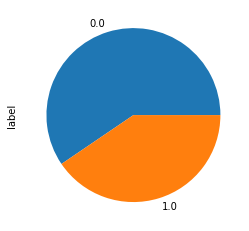

In [ ]:
train_labels['label'].value_counts().plot(kind='pie')

There is a class imbalance in the training data with significantly more non-cancerous images (label '0') versus cancerous (label '1').  I will reduce the size of label 0 by random undersampling of that set in order to match the same size as the set of images with label 1.

In [ ]:
#split into two sets based on labels
train_labels_pos = train_labels[train_labels['label']==1]
train_labels_neg = train_labels[train_labels['label']==0]

In [ ]:
#take a random sample of the neg labels of the same size as the set of pos labels
train_labels_neg = train_labels_neg.sample(n = train_labels_pos.shape[0])

In [ ]:
#confirm both sets are of the same size
print(train_labels_neg.shape[0])
print(train_labels_pos.shape[0])

89117
89117


In [ ]:
#combine and randomize the two sets
train_labels_balanced = pd.concat([train_labels_neg,train_labels_pos]).sample(frac=1, random_state=12345).reset_index(drop=True)
train_labels_balanced.head()

,id,label
0,d01d5110fb36a734e072280eef85a78f0bc59ae4,0.0
1,eae0400f8d0b0e50d6b6a3d0109161d4350bfdbe,1.0
2,5117a86be1ab45d86e29bd4166eec7fdca3cf425,1.0
3,12e65c1e7ad4b0aff1a716ab5da24bb5e149bea4,1.0
4,e2d5a45489fcbf35ed89c389a99af8490167e2fe,0.0


In [ ]:
#confirm final set has the expected amount and shape
train_labels_balanced.shape

(178234, 2)

In [ ]:
#confirm final set has the expected value counts
train_labels_balanced['label'].value_counts()

0.0    89117
1.0    89117
Name: label, dtype: int64

<AxesSubplot:ylabel='label'>

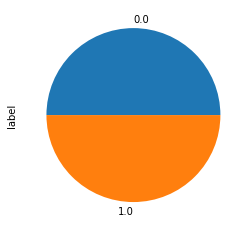

In [ ]:
train_labels_balanced['label'].value_counts().plot(kind='pie')

Now I will look at a several images to see what we are actually trying to classif and confirm they are of the expected size

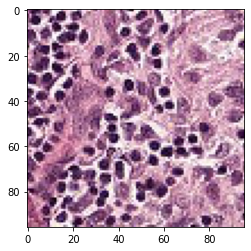

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(f'../input/histopathologic-cancer-detection/train/{train_labels_balanced.iloc[47,0]}.tif')
imgplot = plt.imshow(img)

In [ ]:
print(img.shape)

(96, 96, 3)


In [ ]:
sample_imgs = np.random.choice(train_labels_balanced.index,15)


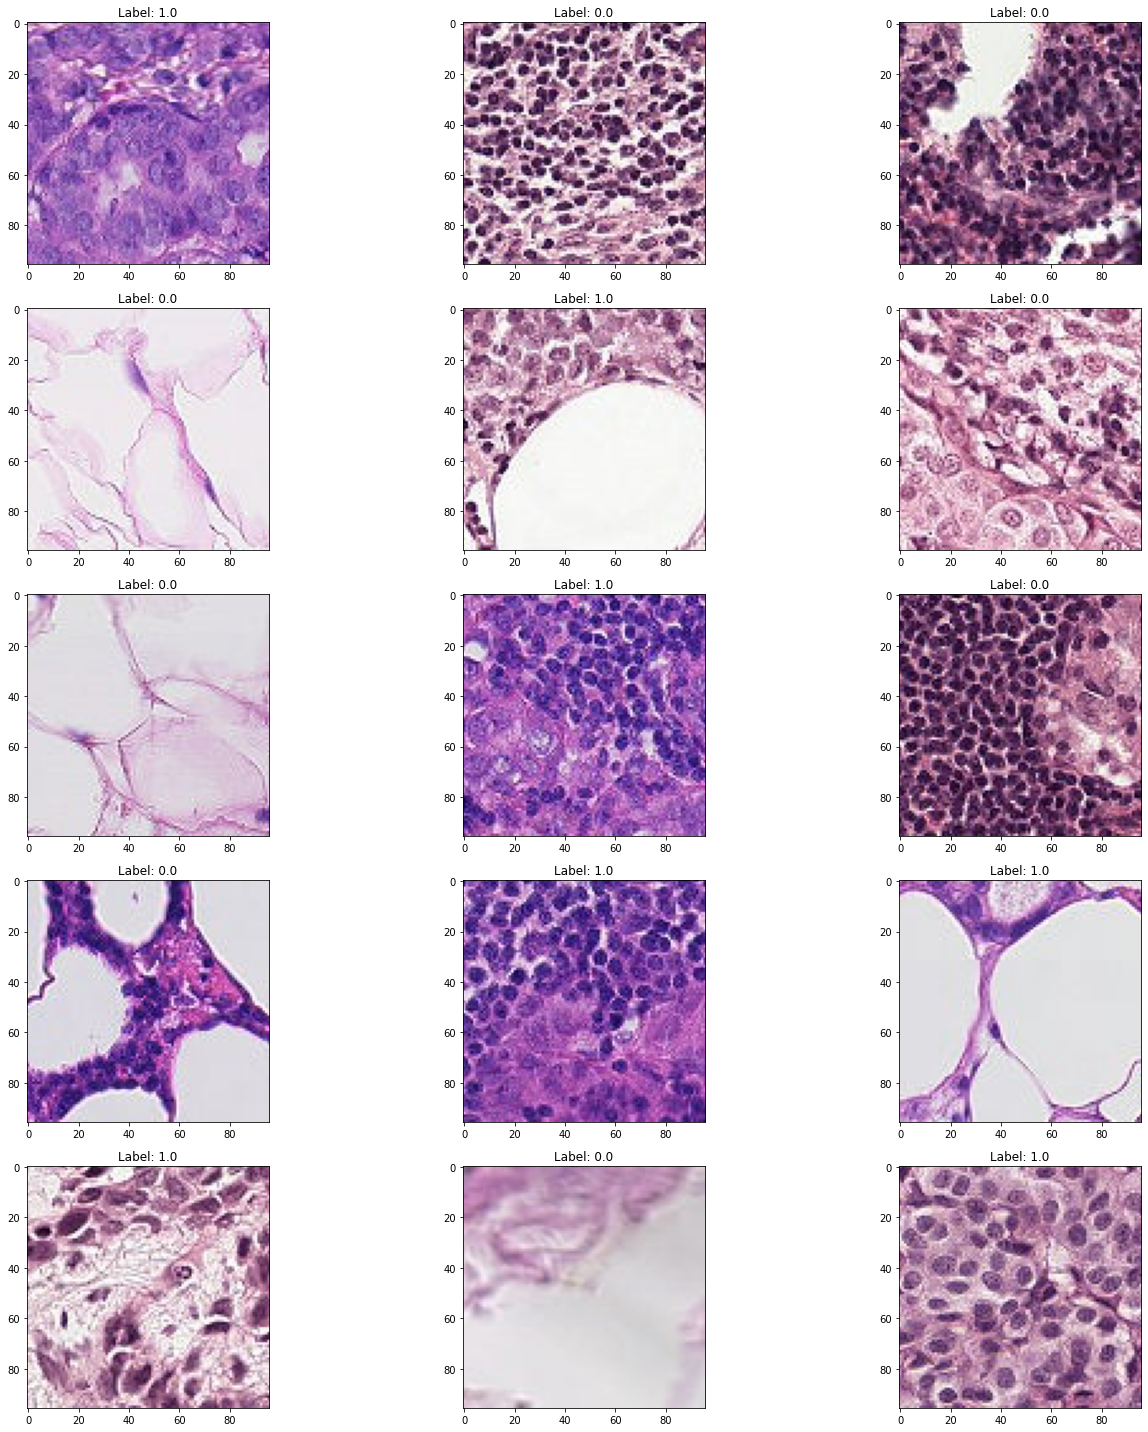

In [ ]:
fig, ax = plt.subplots(5, 3,figsize=(20,20))

for i in range(0, sample_imgs.shape[0]):
    ax = plt.subplot(5, 3, i+1)
    img = mpimg.imread(f'../input/histopathologic-cancer-detection/train/{train_labels_balanced.iloc[sample_imgs[i],0]}.tif')
    ax.imshow(img)
    lab = train_labels_balanced.iloc[sample_imgs[i],1]
    ax.set_title('Label: %s'%lab)

plt.tight_layout()

So, we can see some images are vastly different from others, and with no medical training I cant possibly tell which images are indicative of cancer and which arent.  Hopefully, with deep learning, the model will be able to!

## Step 3: Model Architecture

I will initially attempt to use a model architecture based on the VGGNet model.  This utilizes blocks of convulutions in a [Conv-Conv-MaxPool] set repeated n times.  This is a fairly simple architecture for a beginner like my self to develop and understand so I will stick with that for this assignment.

I will try a couple of different block sizes then look to further tune other hyperparameters such as optimization methods and activation functions.

For the first step, I will split the training set into a training subset and a validation subset.  I will use these same subsets throughout this process in order to remain consistent.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_df, valid_df = train_test_split(train_labels_balanced, test_size=0.25, random_state=1234, stratify=train_labels_balanced.label)

In [ ]:
#import tensorflow and keras as well as any necessary packages
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow import keras
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.layers import PReLU
from keras.initializers import Constant

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_df['id'] = train_df['id']+'.tif'
valid_df['id'] = valid_df['id']+'.tif'

In [ ]:
train_df['label'] = train_df['label'].astype(str)
valid_df['label'] = valid_df['label'].astype(str)

In [ ]:
#create the training and validation subsets
train_datagen=ImageDataGenerator(rescale=1/255)

train_generator=train_datagen.flow_from_dataframe(dataframe=train_df,directory="../input/histopathologic-cancer-detection/train/",
                x_col="id",y_col="label",batch_size=64,seed=1234,shuffle=True,
                class_mode="binary",target_size=(96,96))

valid_generator=train_datagen.flow_from_dataframe(dataframe=valid_df,directory="../input/histopathologic-cancer-detection/train/",
                x_col="id",y_col="label",batch_size=64,seed=1234,shuffle=True,
                class_mode="binary",target_size=(96,96))


Found 133675 validated image filenames belonging to 2 classes.
Found 44559 validated image filenames belonging to 2 classes.


In [ ]:

#initial model with 4 sets of 2 convolutional layers
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=(96,96,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dropout(0.25))
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.25))
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])



2022-05-23 00:12:15.787761: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 00:12:15.913549: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 00:12:15.914253: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 00:12:15.915353: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 94, 94, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 94, 94, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 47, 47, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        1

In [ ]:

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=30, verbose=1
)


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-05-23 00:12:19.504941: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-05-23 00:12:21.765897: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2088/2088 [==============================] - 892s 423ms/step - loss: 0.3897 - accuracy: 0.8341 - val_loss: 0.8545 - val_accuracy: 0.6919
Epoch 2/30
2088/2088 [==============================] - 247s 118ms/step - loss: 0.2833 - accuracy: 0.8866 - val_loss: 0.5039 - val_accuracy: 0.7942
Epoch 3/30
2088/2088 [==============================] - 246s 118ms/step - loss: 0.2396 - accuracy: 0.9076 - val_loss: 0.7949 - val_accuracy: 0.7737
Epoch 4/30
2088/2088 [==============================] - 249s 119ms/step - loss: 0.2136 - accuracy: 0.9191 - val_loss: 1.4232 - val_accuracy: 0.6974
Epoch 5/30
2088/2088 [==============================] - 251s 120ms/step - loss: 0.1953 - accuracy: 0.9276 - val_loss: 0.2573 - val_accuracy: 0.8887
Epoch 6/30
2088/2088 [==============================] - 252s 121ms/step - loss: 0.1777 - accuracy: 0.9342 - val_loss: 0.2190 - val_accuracy: 0.9152
Epoch 7/30
2088/2088 [==============================] - 258s 123ms/step - loss: 0.1654 - accuracy: 0.9390 - val_loss: 0.216

In [ ]:

#next model with 3 sets of 5 convolutional layers
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), padding='same',input_shape=(96,96,3)))
model2.add(Activation('relu'))
model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())

model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())

model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())

model2.add(Flatten())
model2.add(Dropout(0.25))
model2.add(Dense(512))
model2.add(Activation('relu'))

model2.add(Dropout(0.25))
model2.add(Dense(256))
model2.add(Activation('relu'))

model2.add(Dropout(0.25))
model2.add(Dense(64))
model2.add(Activation('relu'))

model2.add(Dropout(0.25))
model2.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(0.001)
model2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 96, 96, 32)        896       
_________________________________________________________________
activation_11 (Activation)   (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 94, 94, 32)        9248      
_________________________________________________________________
activation_12 (Activation)   (None, 94, 94, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 92, 92, 32)        9248      
_________________________________________________________________
activation_13 (Activation)   (None, 92, 92, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 90, 90, 32)       

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history2 = model2.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=30, verbose=1
)

Epoch 1/30
2088/2088 [==============================] - 261s 124ms/step - loss: 0.4514 - accuracy: 0.8013 - val_loss: 0.7015 - val_accuracy: 0.7139
Epoch 2/30
2088/2088 [==============================] - 267s 128ms/step - loss: 0.3807 - accuracy: 0.8373 - val_loss: 1.2406 - val_accuracy: 0.5865
Epoch 3/30
2088/2088 [==============================] - 265s 127ms/step - loss: 0.3473 - accuracy: 0.8540 - val_loss: 0.4373 - val_accuracy: 0.8050
Epoch 4/30
2088/2088 [==============================] - 266s 127ms/step - loss: 0.3081 - accuracy: 0.8745 - val_loss: 0.4326 - val_accuracy: 0.8456
Epoch 5/30
2088/2088 [==============================] - 294s 141ms/step - loss: 0.2921 - accuracy: 0.8827 - val_loss: 0.3155 - val_accuracy: 0.8712
Epoch 6/30
2088/2088 [==============================] - 283s 135ms/step - loss: 0.2678 - accuracy: 0.8943 - val_loss: 1.0614 - val_accuracy: 0.6545
Epoch 7/30
2088/2088 [==============================] - 274s 131ms/step - loss: 0.2513 - accuracy: 0.9007 - val_

I will now take a look at the plots of the accuracy of the training vs validation sets to see which model architecture appears to be the best.  I will then move forward with further hyperparameter tuning.

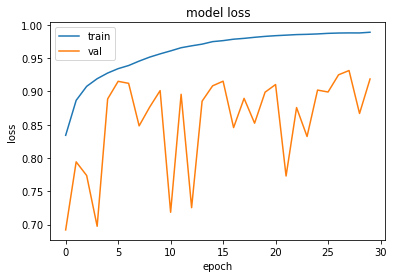

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

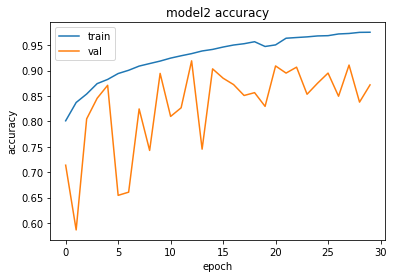

In [ ]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

So, we see the second model with more convolutional layers seems to be slightly better on the validation set.  We are able to reach about 90% accuracy after 10-15 epochs.  Using this model going forward, I will compare a different optimization method and finally different activations in order to tune the hyperparameters.

In [ ]:
#next model with 3 sets of 5 convolutional layers
model3 = Sequential()
model3.add(Conv2D(32, (3, 3), padding='same',input_shape=(96,96,3)))
model3.add(Activation('relu'))
model3.add(Conv2D(32, (3, 3)))
model3.add(Activation('relu'))
model3.add(Conv2D(32, (3, 3)))
model3.add(Activation('relu'))
model3.add(Conv2D(32, (3, 3)))
model3.add(Activation('relu'))
model3.add(Conv2D(32, (3, 3)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(BatchNormalization())

model3.add(Conv2D(64, (3, 3)))
model3.add(Activation('relu'))
model3.add(Conv2D(64, (3, 3)))
model3.add(Activation('relu'))
model3.add(Conv2D(64, (3, 3)))
model3.add(Activation('relu'))
model3.add(Conv2D(64, (3, 3)))
model3.add(Activation('relu'))
model3.add(Conv2D(64, (3, 3)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(BatchNormalization())

model3.add(Conv2D(128, (3, 3)))
model3.add(Activation('relu'))
model3.add(Conv2D(128, (3, 3)))
model3.add(Activation('relu'))
model3.add(Conv2D(128, (3, 3)))
model3.add(Activation('relu'))
model3.add(Conv2D(128, (3, 3)))
model3.add(Activation('relu'))
model3.add(Conv2D(128, (3, 3)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(BatchNormalization())

model3.add(Flatten())
model3.add(Dropout(0.25))
model3.add(Dense(512))
model3.add(Activation('relu'))

model3.add(Dropout(0.25))
model3.add(Dense(256))
model3.add(Activation('relu'))

model3.add(Dropout(0.25))
model3.add(Dense(64))
model3.add(Activation('relu'))

model3.add(Dropout(0.25))
model3.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.RMSprop(0.001)
model3.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


In [ ]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 96, 96, 32)        896       
_________________________________________________________________
activation_29 (Activation)   (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 94, 94, 32)        9248      
_________________________________________________________________
activation_30 (Activation)   (None, 94, 94, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 92, 92, 32)        9248      
_________________________________________________________________
activation_31 (Activation)   (None, 92, 92, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 90, 90, 32)       

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history3 = model3.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=30, verbose=1
)

Epoch 1/30
2088/2088 [==============================] - 346s 165ms/step - loss: 0.4923 - accuracy: 0.7794 - val_loss: 1.1635 - val_accuracy: 0.5699
Epoch 2/30
2088/2088 [==============================] - 279s 134ms/step - loss: 0.4169 - accuracy: 0.8266 - val_loss: 0.5074 - val_accuracy: 0.7919
Epoch 3/30
2088/2088 [==============================] - 263s 126ms/step - loss: 0.3877 - accuracy: 0.8442 - val_loss: 0.3493 - val_accuracy: 0.8613
Epoch 4/30
2088/2088 [==============================] - 283s 136ms/step - loss: 0.3572 - accuracy: 0.8587 - val_loss: 1.0027 - val_accuracy: 0.7054
Epoch 5/30
2088/2088 [==============================] - 284s 136ms/step - loss: 0.3361 - accuracy: 0.8679 - val_loss: 1.4087 - val_accuracy: 0.8262
Epoch 6/30
2088/2088 [==============================] - 282s 135ms/step - loss: 0.3288 - accuracy: 0.8729 - val_loss: 0.4276 - val_accuracy: 0.8207
Epoch 7/30
2088/2088 [==============================] - 256s 123ms/step - loss: 0.3178 - accuracy: 0.8791 - val_

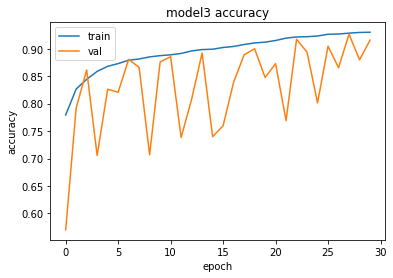

In [ ]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model3 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

So, we see the model with RMSprop as the optimizer does not seem to be as stable at least in the validation set and the accuracy still appears to be improving even after 30 epochs whereas the model utilizing Adam optimizer had converged by that point.  I will continue with the model utilizing Adam optimization, comparing the activation function (relu vs prelu) before determining what the final model will be.

In [ ]:
#next model with 3 sets of 5 convolutional layers, using prelu activations
model4 = Sequential()
model4.add(Conv2D(32, (3, 3), padding='same',input_shape=(96,96,3)))
model4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model4.add(Conv2D(32, (3, 3)))
model4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model4.add(Conv2D(32, (3, 3)))
model4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model4.add(Conv2D(32, (3, 3)))
model4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model4.add(Conv2D(32, (3, 3)))
model4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(BatchNormalization())

model4.add(Conv2D(64, (3, 3)))
model4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model4.add(Conv2D(64, (3, 3)))
model4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model4.add(Conv2D(64, (3, 3)))
model4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model4.add(Conv2D(64, (3, 3)))
model4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model4.add(Conv2D(64, (3, 3)))
model4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(BatchNormalization())

model4.add(Conv2D(128, (3, 3)))
model4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model4.add(Conv2D(128, (3, 3)))
model4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model4.add(Conv2D(128, (3, 3)))
model4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model4.add(Conv2D(128, (3, 3)))
model4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model4.add(Conv2D(128, (3, 3)))
model4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(BatchNormalization())

model4.add(Flatten())
model4.add(Dropout(0.25))
model4.add(Dense(512))
model4.add(PReLU(alpha_initializer=Constant(value=0.25)))

model4.add(Dropout(0.25))
model4.add(Dense(256))
model4.add(PReLU(alpha_initializer=Constant(value=0.25)))

model4.add(Dropout(0.25))
model4.add(Dense(64))
model4.add(PReLU(alpha_initializer=Constant(value=0.25)))

model4.add(Dropout(0.25))
model4.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.RMSprop(0.001)
model4.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


In [ ]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 96, 96, 32)        896       
_________________________________________________________________
p_re_lu (PReLU)              (None, 96, 96, 32)        294912    
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 94, 94, 32)        9248      
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 94, 94, 32)        282752    
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 92, 92, 32)        9248      
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 92, 92, 32)        270848    
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 90, 90, 32)       

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history4 = model4.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=30, verbose=1
)

Epoch 1/30
2088/2088 [==============================] - 335s 159ms/step - loss: 0.5052 - accuracy: 0.7716 - val_loss: 0.4533 - val_accuracy: 0.7942
Epoch 2/30
2088/2088 [==============================] - 279s 134ms/step - loss: 0.3804 - accuracy: 0.8386 - val_loss: 0.6008 - val_accuracy: 0.7797
Epoch 3/30
2088/2088 [==============================] - 284s 136ms/step - loss: 0.3447 - accuracy: 0.8565 - val_loss: 0.3143 - val_accuracy: 0.8677
Epoch 4/30
2088/2088 [==============================] - 301s 144ms/step - loss: 0.3184 - accuracy: 0.8705 - val_loss: 0.5506 - val_accuracy: 0.8399
Epoch 5/30
2088/2088 [==============================] - 282s 135ms/step - loss: 0.2894 - accuracy: 0.8851 - val_loss: 0.4295 - val_accuracy: 0.8022
Epoch 6/30
2088/2088 [==============================] - 282s 135ms/step - loss: 0.2693 - accuracy: 0.8956 - val_loss: 0.3513 - val_accuracy: 0.8545
Epoch 7/30
2088/2088 [==============================] - 354s 170ms/step - loss: 0.2476 - accuracy: 0.9049 - val_

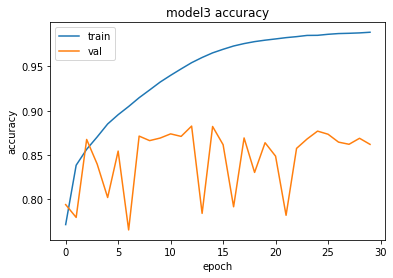

In [ ]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('model3 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

So, we see with PReLU activation, the model converged faster (reaching nearly 100% accuracy on the training set within 30 epochs) and the validation set accuracy was much more stable.  This makes sense as the ReLU activation suffers from vanishing gradients and can essentially "turn off" nodes which may actually be the nodes we need for different instances.  From the images, we know that not every image is perfectly centered so the important "nodes" in our model could really occur anywhere and we shouldnt look to turn them completely off if at all possible.

In [ ]:
test_set = os.listdir('../input/histopathologic-cancer-detection/test/')


In [ ]:
test_df = pd.DataFrame(test_set)
test_df.columns = ['id']
test_df.head()

,id
0,a7ea26360815d8492433b14cd8318607bcf99d9e.tif
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif


In [ ]:
test_datagen=ImageDataGenerator(rescale=1/255)

test_generator=test_datagen.flow_from_dataframe(dataframe=test_df,directory="../input/histopathologic-cancer-detection/test/",
                x_col="id",batch_size=64,seed=1234,shuffle=False,
                class_mode=None,target_size=(96,96))

Found 57458 validated image filenames.


In [ ]:
STEP_SIZE_TEST=test_generator.n/2

preds = model4.predict_generator(generator=test_generator,steps=STEP_SIZE_TEST, verbose = 1)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


28729/28729 [==============================] - 323s 11ms/step


In [ ]:
predictions = []

for pred in preds:
    if pred >= 0.5:
        predictions.append(1)
    else:
        predictions.append(0)

predictions[:10]

[1, 0, 0, 0, 1, 1, 0, 1, 0, 0]

In [ ]:
submission = test_df.copy()
submission['id']=submission['id'].str[:-4]
submission['label']=predictions
submission.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,1
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,0
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,1


In [ ]:
submission.to_csv('submission.csv',index=False)